# Convolutional Neural Network for Image Recognition

"BlendedLeaf" - AN2DL homework 1
## Team
"Augmented Tensorflop"
- Daniele Civati
- Matteo Palazzoli
- Francesco Panebianco

## Imports & suppress warnings

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from math import floor

#----------------------------------------------------------
# suppress warnings

import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Let's now import the tensorflow addons, that will be useful for our custom optimizer. The exported model will have the same architecture, weights and other parameters but Adam as optimizer to avoid import error for unavaiable libraries.

In [2]:
import tensorflow_addons as tfa

## Data retrieval and split

In [3]:
# path used in Kaggle
path_to_dataset = '../input/homework1/training_data_final/'

# let's get a sample to get the dimensions (that are 96x96)
image_representative = PIL.Image.open(path_to_dataset + 'Species1/00000.jpg').convert('RGB')
img_width = image_representative.size[0]
img_height = image_representative.size[1]

data = []
labels = []

# get the files and turn the information into lists
for class_num in range(8):
    for root, dirs, files in os.walk(path_to_dataset + 'Species' + str(class_num + 1) + '/'):
        for file in files:
            file_path = root + file
            image=tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', 
            target_size= (img_width, img_height))
            image=np.array(image)
        
            # Add data point and label to the list
            data.append(image)
            labels.append(class_num)

# convert to numpy
data = np.array(data)

# preprocess input for VGG16 and convert labels to categorical
data = keras.applications.vgg16.preprocess_input(data)

ind_labels = np.array(labels)

# convert the labels to one-hot-encoding
labels = keras.utils.to_categorical(ind_labels, num_classes=8)

print('Data shape: {}'.format(data.shape))
print('Labels shape: {}'.format(labels.shape))

# decide if there will be a separate test set or not
test = True
if(test):
    X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size=0.15, shuffle=True, stratify=labels)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.08 / 0.85, shuffle=True, stratify=y_trainval)
else:
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.08, shuffle=True, stratify=labels)
print('\n\nTraining Set:')
print('Data shape: {}'.format(X_train.shape))
print('Labels shape: {}'.format(y_train.shape))
print('\nValidation Set:')
print('Data shape: {}'.format(X_valid.shape))
print('Labels shape: {}'.format(y_valid.shape))
if(test):
    print('\nTest Set:')
    print('Data shape: {}'.format(X_test.shape))
    print('Labels shape: {}'.format(y_test.shape))

Data shape: (3542, 96, 96, 3)
Labels shape: (3542, 8)


Training Set:
Data shape: (2726, 96, 96, 3)
Labels shape: (2726, 8)

Validation Set:
Data shape: (284, 96, 96, 3)
Labels shape: (284, 8)

Test Set:
Data shape: (532, 96, 96, 3)
Labels shape: (532, 8)


## Data Augmentation

In [4]:
# let's duplicate the data for the next augmentation techniques,
# because the CutMix and MixUp utilities take 2 inputs to give one output.

BATCH_SIZE = 32
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

# conversion to tf.data.Dataset type
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE)
if(test):
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

### CutMix Augmentation Technique

In [5]:
# CUTMIX utility function
AUTO = tf.data.AUTOTUNE

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

In [6]:
## CUTMIX augmentation technique from Keras documentation
IMG_SIZE = 96

# the function is decorated with this annotation for performance improvement
@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)
    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)
    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)
    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry
    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)
    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1
    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1
    return boundaryx1, boundaryy1, target_h, target_w

@tf.function
def cutmix(train_ds_one, train_ds_two):
    image1, label1 = train_ds_one
    image2, label2 = train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [7]:
# Apply our `cutmix` utility
train_ds = train_ds.map(
    lambda ds_one, ds_two: cutmix(ds_one, ds_two), num_parallel_calls=AUTO
)

class_names = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

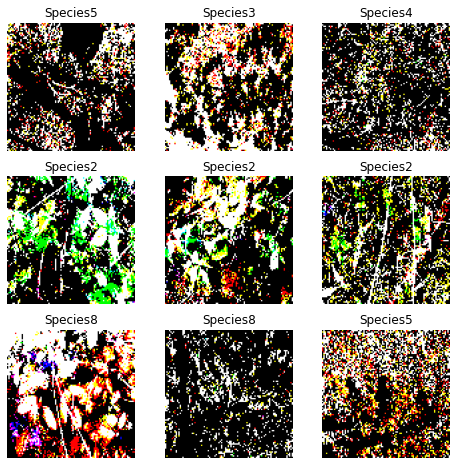

In [8]:
# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i]) 
    plt.axis("off")

# the images below are very strange because of VGG16's preprocessing:
# The images are converted from RGB to BGR, 
# then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. 
# We can still see the "boxes" generated by CutMix

#### Class weights

In [9]:
weight_vector = compute_class_weight(class_weight='balanced', classes=[*range(8)], y=ind_labels)
weight_vector[0] = weight_vector[0] * 2.0
weight_vector[7] = weight_vector[7] * 1.7
class_weights = {i : weight_vector[i] for i in range(8)}

## Fine Tuning
With VGG16 pretrained on ImageNet

In [10]:
pretrained_model = keras.applications.VGG16(include_top=False,
                                           weights='imagenet',
                                           input_shape=(img_width, img_height, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [12]:
pretrained_model.trainable = True

# model
ft_model = keras.Sequential(name = 'VGG16_BlendedLeaf')
ft_model.add(keras.layers.Input(shape=(img_width, img_height, 3)))
ft_model.add(keras.layers.RandomFlip())
ft_model.add(keras.layers.RandomTranslation(0.15, 0.15))
ft_model.add(pretrained_model)
ft_model.add(keras.layers.Flatten(name='flattener'))
ft_model.add(keras.layers.Dropout(0.4))
ft_model.add(keras.layers.Dense(256, activation='relu',
    kernel_initializer = keras.initializers.HeUniform(), name='classifier'))
ft_model.add(keras.layers.Dense(8, activation='softmax',
    kernel_initializer = keras.initializers.GlorotUniform(), name='output'))

# Freeze pretrained weights up to a certain limit
freeze_layer_limit = 7

# Freeze first layers
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:freeze_layer_limit]):
    layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

ft_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=tfa.optimizers.Yogi(1e-4), metrics='accuracy')
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "VGG16_BlendedLeaf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_translation (RandomTr (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flattener (Flatten)          (None, 4608)              0   

## Model Training
An early stopping callback is added to the process to limit overfitting, with a patience of 15.
We perform the training on the partially unfrozen model because it gives better performance than plain Trasnfer Learning.
#### Notes
Please note: sometimes there's an unlucky initialization which prevents convergence. In that case just re-run the following cell.

In [13]:
# Train the model
ft_history = ft_model.fit(
    x = train_ds,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_ds,
    class_weight=class_weights,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
).history

Epoch 1/200
86/86 [==============================] - 15s 58ms/step - loss: 2.9846 - accuracy: 0.1548 - val_loss: 2.0154 - val_accuracy: 0.1232
Epoch 2/200
86/86 [==============================] - 4s 48ms/step - loss: 2.4216 - accuracy: 0.1761 - val_loss: 1.7754 - val_accuracy: 0.3099
Epoch 3/200
86/86 [==============================] - 4s 47ms/step - loss: 2.3202 - accuracy: 0.2671 - val_loss: 1.7426 - val_accuracy: 0.3521
Epoch 4/200
86/86 [==============================] - 4s 48ms/step - loss: 2.2569 - accuracy: 0.3147 - val_loss: 1.4348 - val_accuracy: 0.4577
Epoch 5/200
86/86 [==============================] - 4s 47ms/step - loss: 2.1786 - accuracy: 0.3511 - val_loss: 1.4193 - val_accuracy: 0.4577
Epoch 6/200
86/86 [==============================] - 4s 47ms/step - loss: 2.2670 - accuracy: 0.2953 - val_loss: 1.3999 - val_accuracy: 0.4085
Epoch 7/200
86/86 [==============================] - 4s 47ms/step - loss: 2.1274 - accuracy: 0.3577 - val_loss: 1.5659 - val_accuracy: 0.4261
Epoch

## Prediction Analysis

Accuracy: 0.9117
Precision: 0.903
Recall: 0.882
F1: 0.8905


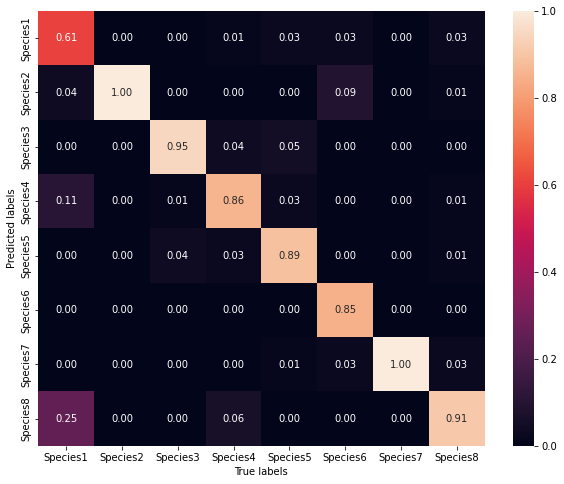

In [14]:
# Predict the test set with the CNN
# in case there's no test set, use validation set (but the results will be less representative)
if(test):
    testset = X_test
    testlabels = y_test
else:
    testset = X_valid
    testlabels = y_valid
predictions = ft_model.predict(testset)
predictions.shape
label_classes = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

# Compute the confusion matrix
true_ = np.argmax(testlabels, axis=-1)
pred_ = np.argmax(predictions, axis=-1)
cm = confusion_matrix(true_, pred_)
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(true_, pred_)
precision = precision_score(true_, pred_, average='macro')
recall = recall_score(true_, pred_, average='macro')
f1 = f1_score(true_, pred_, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
cm.T

array([[17,  0,  0,  1,  2,  1,  0,  2],
       [ 1, 80,  0,  0,  0,  3,  0,  1],
       [ 0,  0, 73,  3,  4,  0,  0,  0],
       [ 3,  0,  1, 66,  2,  0,  0,  1],
       [ 0,  0,  3,  2, 71,  0,  0,  1],
       [ 0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  1,  1, 81,  2],
       [ 7,  0,  0,  5,  0,  0,  0, 69]])

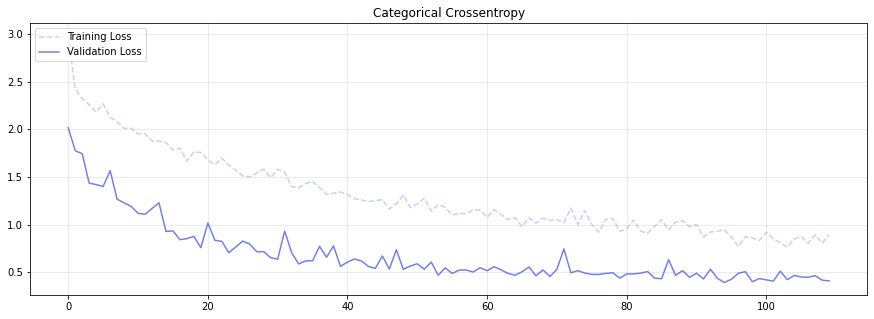

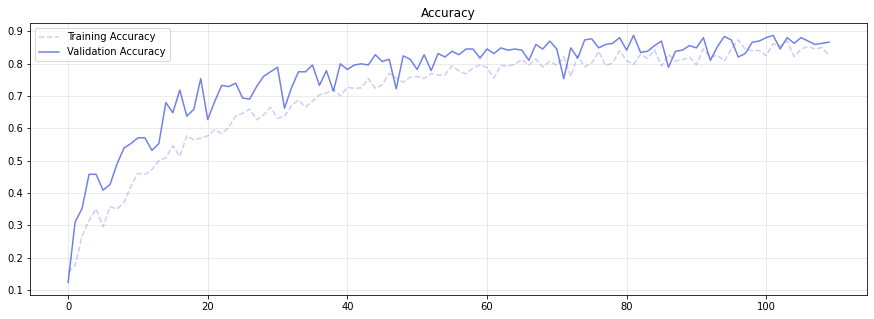

In [16]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], label='Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(ft_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], label = 'Training Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Model save & export
We export the model with Adam optimizer, so it can run in an environment without tensorflow-addons installed.

In [17]:
ft_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(1e-4), metrics='accuracy')

In [18]:
# Save the best model
ft_model.save('VGG16_BlendedLef')

!zip -r VGG16_BlendedLeaf.zip ./VGG16_BlendedLeaf

	zip warning: name not matched: ./VGG16_BlendedLeaf

zip error: Nothing to do! (try: zip -r VGG16_BlendedLeaf.zip . -i ./VGG16_BlendedLeaf)
